In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../upliftnet")

In [3]:
import logging
logging.getLogger('tensorflow').disabled = True

In [4]:
import numpy as np
import keras
from keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt

import data
import net
import plots
import metrics

### Config

In [5]:
# sample size
N_TREATMENT = 80_000
N_CONTROL = 20_000

# param dist
MU = [0, 0, 0]
COV = None

# ground truth
TREATMENT_TRUTH = [-4.5, -1.5, -0.8, 1.2]
CONTROL_TRUTH = [-5, -1.8, -0.8, -1.2]

# test set ration
TEST_RATIO = 0.8

### Synthetic dataset

In [6]:
X, y, treatment = data.generate_logistic_data(
    treatment_coefs=TREATMENT_TRUTH,
    control_coefs=CONTROL_TRUTH,
    n_treatment=N_TREATMENT,
    n_control=N_CONTROL,
    mu=MU,
    cov=COV
)

In [7]:
y.mean()

0.05045

In [8]:
indices = np.random.permutation(X.shape[0])
n_train = int(X.shape[0] * TEST_RATIO)
training_idx, test_idx = indices[:n_train], indices[n_train:]

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X[training_idx], y[training_idx], treatment[training_idx]))
    .shuffle(buffer_size=5000, reshuffle_each_iteration=True)
    .batch(1_000)
)

X_test, y_test, treatment_test = X[test_idx], y[test_idx], treatment[test_idx]

### Simple MLP model

In [9]:
class UpliftMLP(net.UpliftNet):
    def __init__(self, hidden_sizes):
        super().__init__()
        self.dense = [
            layers.Dense(size, activation='relu')
            for size in hidden_sizes
        ]
        self.out = layers.Dense(1, activation='linear')
        
    def call(self, inputs):
        densei = self.dense[0](inputs)
        for dense in self.dense[1:]:
            densei = dense(densei)
        return self.out(densei)

uplift_model = UpliftMLP([32, 16])
uplift_model.compile(optimizer=keras.optimizers.Adam())

In [10]:
res = uplift_model.fit(
    x=train_dataset,
    epochs=3
)

Epoch 1/3
80/80 [==============================] - 2s 6ms/step - loss: -2.7141e-05 - avg_promotional_cumulative_gain: 4.8074e-05
Epoch 2/3
80/80 [==============================] - 1s 7ms/step - loss: -4.8835e-05 - avg_promotional_cumulative_gain: 6.2803e-05
Epoch 3/3
80/80 [==============================] - 1s 7ms/step - loss: -5.7183e-05 - avg_promotional_cumulative_gain: 6.3865e-05


### Evaluate on test set

In [11]:
preds_test = np.squeeze(uplift_model.predict(X[test_idx]), 1)

625/625 [==============================] - 1s 1ms/step


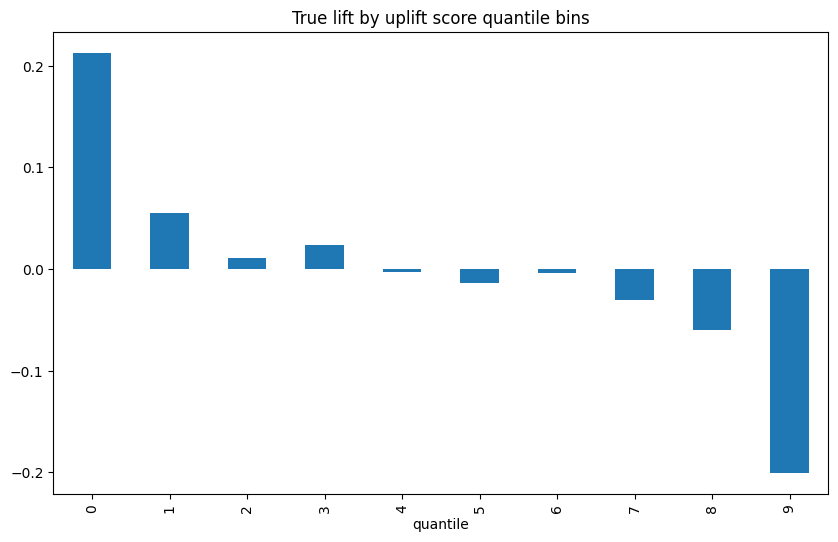

In [12]:
plots.true_lift_plot(y_test, preds_test, treatment_test);

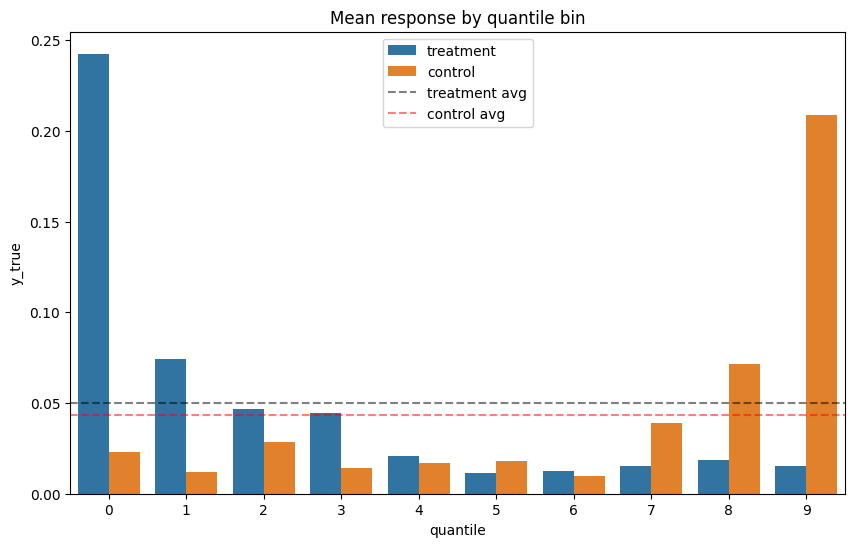

In [13]:
plots.target_plot(y_test, preds_test, treatment_test);

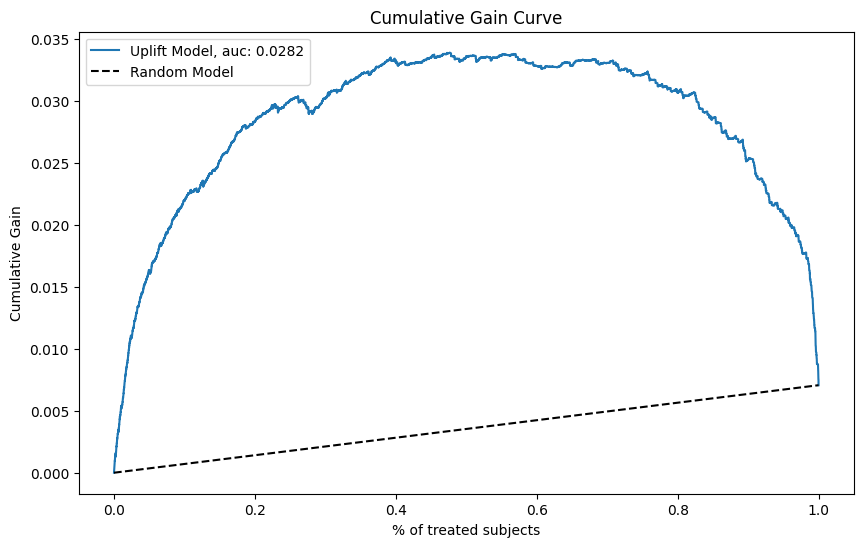

In [14]:
plots.cumulative_gain_plot(y_test, preds_test, treatment_test);